# Importing Lib



In [1]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

2025-04-14 11:51:59.831602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744631520.064343      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744631520.130060      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [3]:
data = pd.read_csv('/kaggle/input/vibe-nb/ALL_FAIL_LOG_VIBE_0_Add_Random.csv')


# Preprocessing and Exploring data



In [4]:
print("Dataset Shape:", data.shape)
print("\nColumns:\n", data.columns)
print("\nSample Data:\n", data.head())
print("\nMissing Values:\n", data.isnull().sum())

Dataset Shape: (8638, 8)

Columns:
 Index(['LineNo', 'TimeUS', 'IMU', 'VibeX', 'VibeY', 'VibeZ', 'Clip', 'labels'], dtype='object')

Sample Data:
    LineNo     TimeUS  IMU     VibeX     VibeY     VibeZ  Clip  labels
0  424709  503763414    0  0.120009  0.108398  0.148239     0       4
1  426871  506163287    0  0.003210  0.003270  0.002992     0       4
2  435120  516463332    0  0.002998  0.003317  0.002864     0       4
3  145047  192963617    0  0.163687  0.116775  0.247265     0       0
4  430951  511263746    0  0.002952  0.002766  0.002777     0       4

Missing Values:
 LineNo    0
TimeUS    0
IMU       0
VibeX     0
VibeY     0
VibeZ     0
Clip      0
labels    0
dtype: int64


In [5]:
print("\nData Types:\n", data.dtypes)


Data Types:
 LineNo      int64
TimeUS      int64
IMU         int64
VibeX     float64
VibeY     float64
VibeZ     float64
Clip        int64
labels      int64
dtype: object


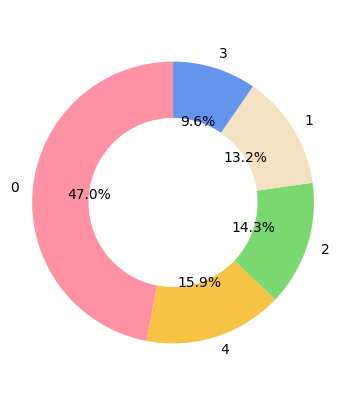

In [6]:

if 'labels' in data.columns:
    label_counts = data['labels'].value_counts()
    # Define specific colors for 5 labels
    colors = ["#FF91A4", "#f6c344", "#79d970", "#F4E1C1", "#6495ED"]

    # Plot the donut chart
    plt.figure(figsize=(4, 5))
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'width': 0.4})
    plt.axis('equal')
    plt.show()



In [7]:
# Encoding Categorical Data
if 'labels' in data.columns:
    label_encoder = LabelEncoder()
    data['labels'] = label_encoder.fit_transform(data['labels'])
    print("\nLabel Encoding Complete. Classes:", label_encoder.classes_)


Label Encoding Complete. Classes: [0 1 2 3 4]


In [8]:
# Feature Selection
X = data.drop(columns=['labels']).values  # Features
y = data['labels'].values  # Target

In [9]:
X.shape

(8638, 7)

In [10]:
# Scaling Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# One-hot encode the labels
y_encoded = to_categorical(y, num_classes=len(np.unique(y)))

In [12]:
# Reshaping for TCN (samples, time_steps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [13]:
X_reshaped.shape

(8638, 1, 7)

In [14]:
for label in data['labels'].unique():
    print(f"\nValues for label: {label}")
    print(data[data['labels'] == label].head())


Values for label: 4
    LineNo     TimeUS  IMU     VibeX     VibeY     VibeZ  Clip  labels
0   424709  503763414    0  0.120009  0.108398  0.148239     0       4
1   426871  506163287    0  0.003210  0.003270  0.002992     0       4
2   435120  516463332    0  0.002998  0.003317  0.002864     0       4
4   430951  511263746    0  0.002952  0.002766  0.002777     0       4
14  387259  462163394    0  0.143049  0.153651  0.242598     0       4

Values for label: 0
    LineNo     TimeUS  IMU     VibeX     VibeY     VibeZ  Clip  labels
3   145047  192963617    0  0.163687  0.116775  0.247265     0       0
6     6546   21363951    0  0.002655  0.002836  0.002889     0       0
7   136590  183564045    0  0.161763  0.134775  0.262035     0       0
8    25476   59563665    0  0.102368  0.101971  0.117639     0       0
10  145589  193563377    0  0.160231  0.124077  0.282388     0       0

Values for label: 2
    LineNo     TimeUS  IMU         VibeX         VibeY         VibeZ  Clip  \
5   227

# Model

In [15]:
# Define the TCN Block
def TCN_Block(filters, kernel_size, dilation_rate):
    return tf.keras.Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate),
        BatchNormalization(),
        Activation('relu')
    ])

In [16]:
# Define the Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        u_t = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a_t = tf.nn.softmax(tf.tensordot(u_t, self.u, axes=1), axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(a_t, -1), axis=1)
        return output

In [17]:
# Define the TCN with Attention Model
def build_tcn_attention_model(input_shape, num_classes):
    # inputs = Input(shape=input_shape)
# def build_tcn_attention_model(X_reshaped, num_classes):
    inputs = Input(shape=(X_reshaped.shape[1], X_reshaped.shape[2]))
     # Replacing input_shape with X_reshaped.shape
    # TCN Layers
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Attention mechanism
    attention_output = AttentionLayer()(x)

    # Classification
    classification = Dense(num_classes, activation='softmax')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])

    return model


In [18]:
# input_shape
X_reshaped.shape[2]

7

In [19]:
X_reshaped.shape[1]

1

In [20]:
X_reshaped.shape[0]

8638

In [21]:
X_reshaped.shape

(8638, 1, 7)

In [22]:
# Input shape for TCN
input_shape = (X_reshaped.shape[1], X_reshaped.shape[2])
num_classes = y_encoded.shape[1]

In [23]:
# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuraciesKF = []
label_accuraciesKF = []

for train_index, val_index in kf.split(X_reshaped):
    print(f"\nTraining fold {fold_no}...")

    # Split data
    X_train_foldKF, X_val_foldKF = X_reshaped[train_index], X_reshaped[val_index]
    y_train_foldKF, y_val_foldKF = y_encoded[train_index], y_encoded[val_index]

    # Build and train the model
    # modelKF = build_tcn_attention_model(input_shape, num_classes)
    modelKF = build_tcn_attention_model(X_reshaped, num_classes)
    modelKF.fit(X_train_foldKF, y_train_foldKF, epochs=50, batch_size=32, verbose=0, validation_data=(X_val_foldKF, y_val_foldKF))

    # Evaluate the model
    lossKF, accuracyKF = modelKF.evaluate(X_val_foldKF, y_val_foldKF, verbose=0)
    print(f"Validation Accuracy for fold {fold_no}: {accuracyKF:.4f}")
    accuraciesKF.append(accuracyKF)

    # Predictions
    y_predKF = modelKF.predict(X_val_foldKF)
    y_pred_classesKF = np.argmax(y_predKF, axis=1)
    y_true_classesKF = np.argmax(y_val_foldKF, axis=1)

    # Accuracy per label
    label_accKF = []
    for label in range(num_classes):
        label_indicesKF = (y_true_classesKF == label)
        label_accKF.append(accuracy_score(y_true_classesKF[label_indicesKF], y_pred_classesKF[label_indicesKF]))
    label_accuraciesKF.append(label_accKF)

    fold_no += 1




Training fold 1...


I0000 00:00:1744631534.470323      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744631534.471019      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1744631539.970385      93 service.cc:148] XLA service 0x2ddf3b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744631539.970894      93 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744631539.970911      93 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744631540.420884      93 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744631543.119607      93 device_compiler.h:188] Compiled cluster u

Validation Accuracy for fold 1: 0.8409
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step 

Training fold 2...
Validation Accuracy for fold 2: 0.6076
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step 

Training fold 3...
Validation Accuracy for fold 3: 0.6493
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step 

Training fold 4...
Validation Accuracy for fold 4: 0.5026
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Training fold 5...
Validation Accuracy for fold 5: 0.6028
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [24]:
modelKF.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 1, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_12 (Sequential)           │ (None, 1, 64)               │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_13 (Sequential)           │ (None, 1, 64)               │          12,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_14 (Sequential)           │ (None, 1, 64)               │          12,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_4 (AttentionLayer)   │ (None, 64)                  │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,521 (365.32 KB)

 Trainable params: 31,045 (121.27 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 62,092 (242.55 KB)

In [25]:
# Calculate average accuracy
average_accuracyKF = np.mean(accuraciesKF)
print(f"\nAverage Accuracy across all folds: {average_accuracyKF:.4f}")


Average Accuracy across all folds: 0.6406


In [26]:
# Average accuracy per label
label_accuraciesKF = np.mean(label_accuraciesKF, axis=0)
for idx, acc in enumerate(label_accuraciesKF):
    print(f"Label {idx} Accuracy: {acc:.4f}")

Label 0 Accuracy: 0.8955
Label 1 Accuracy: 0.8366
Label 2 Accuracy: 0.2439
Label 3 Accuracy: 0.3372
Label 4 Accuracy: 0.2932


In [27]:
# Evaluate the last fold predictions
y_predKF = modelKF.predict(X_val_foldKF)
y_pred_classesKF = np.argmax(y_predKF, axis=1)
y_true_classesKF = np.argmax(y_val_foldKF, axis=1)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [28]:
feature_names = ["LineNo", "TimeUS", "IMU", "VibeX", "VibeY", "VibeZ", "Clip"]

In [29]:
# import pandas as pd
# import numpy as np


# # Step 1: Get Model Predictions
# y_pred_probs = modelKF.predict(X_reshaped)  # Get probabilities
# y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
# y_true_labels = np.argmax(y_encoded, axis=1)  # Convert true labels to class labels

# # Step 2: Filter only misclassified samples
# mismatch_indices = y_true_labels != y_pred_labels  # Boolean mask for incorrect predictions

# # Step 3: Print only misclassified rows
# df_mismatches = pd.DataFrame(X_reshaped[mismatch_indices].reshape(-1, X_reshaped.shape[2]))  # Flatten features
# df_mismatches['Actual_Label'] = y_true_labels[mismatch_indices]
# df_mismatches['Predicted_Label'] = y_pred_labels[mismatch_indices]

# print(df_mismatches)  # Print all misclassified cases




In [30]:
# import pandas as pd
# import numpy as np

# feature_names = ["LineNo", "abTimeUS", "abI", "abGyrX", "abGyrY", "abGyrZ", "abAccX",
#        "abAccY", "abAccZ", "abEG", "abEA", "abT", "abGH", "abAH", "abGHz",
#        "abAHz"]

# # Step 1: Get Model Predictions
# y_pred_probs = modelKF.predict(X_reshaped)  # Get probabilities
# y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
# y_true_labels = np.argmax(y_encoded, axis=1)  # Convert true labels to class labels

# # Step 2: Identify misclassified samples and their indices
# mismatch_indices = np.where(y_true_labels != y_pred_labels)[0]  # Get actual indices

# # Step 3: Create DataFrame of misclassified samples with indices
# df_mismatches = pd.DataFrame(X_reshaped[mismatch_indices].reshape(-1, X_reshaped.shape[2]), columns=feature_names)
# df_mismatches['Index'] = mismatch_indices  # Add original index
# df_mismatches['Actual_Label'] = y_true_labels[mismatch_indices]
# df_mismatches['Predicted_Label'] = y_pred_labels[mismatch_indices]

# # Print misclassified samples with their original indices
# print(df_mismatches[['Index', 'Actual_Label', 'Predicted_Label'] + feature_names])


In [31]:
# # Step 1: Identify correctly classified indices
# correct_indices = np.where(y_true_labels == y_pred_labels)[0]

# # Step 2: Create DataFrame of correctly classified samples
# df_correct = pd.DataFrame(X_reshaped[correct_indices].reshape(-1, X_reshaped.shape[2]), columns=feature_names)
# df_correct['Index'] = correct_indices  # Add original index
# df_correct['Actual_Label'] = y_true_labels[correct_indices]
# df_correct['Predicted_Label'] = y_pred_labels[correct_indices]

# # Step 3: Save to CSV
# df_correct.to_csv("correctly_classified.csv", index=False)

# # Print first few rows
# print(df_correct.head())


In [32]:
# df_mismatches.to_csv("misclassified_samples.csv", index=False)
# print("CSV file 'misclassified_samples.csv' saved successfully!")


In [33]:
# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classesKF, y_pred_classesKF,digits = 4))


Classification Report:

              precision    recall  f1-score   support

           0     0.5442    0.9432    0.6902       810
           1     0.8125    0.9420    0.8725       207
           2     1.0000    0.0278    0.0541       252
           3     0.9706    0.1844    0.3099       179
           4     1.0000    0.1505    0.2617       279

    accuracy                         0.6028      1727
   macro avg     0.8654    0.4496    0.4376      1727
weighted avg     0.7607    0.6028    0.5106      1727



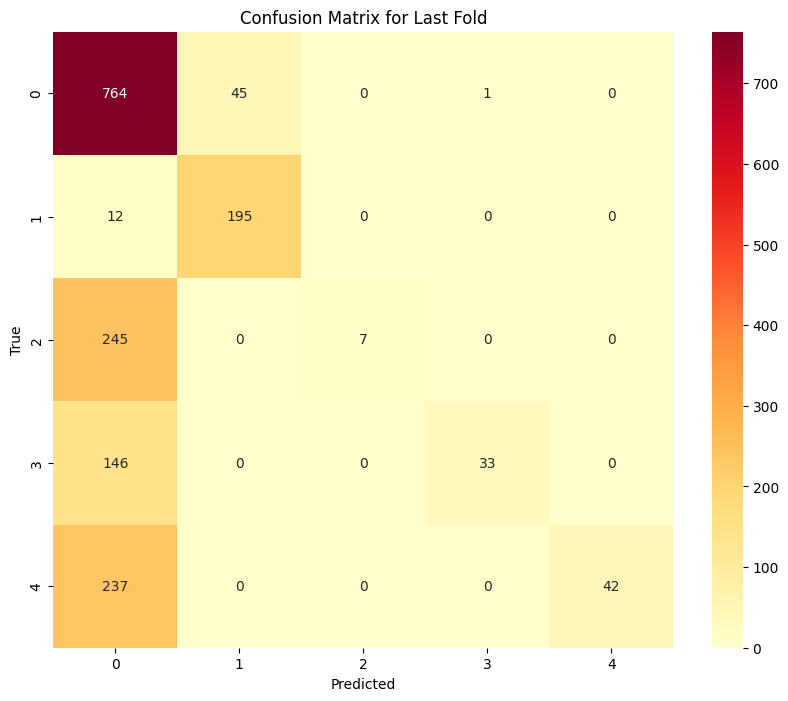

In [34]:
# Confusion Matrix
conf_matrixKF = tf.math.confusion_matrix(y_true_classesKF, y_pred_classesKF)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrixKF, annot=True, fmt='d', cmap='YlOrRd')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion Matrix for Last Fold')
plt.show()


Label Distribution:
 labels
0    4059
4    1376
2    1237
1    1138
3     828
Name: count, dtype: int64


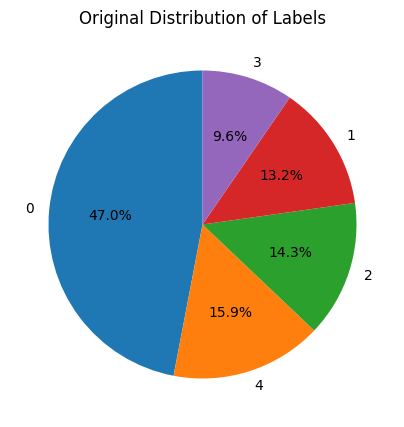

In [35]:
if 'labels' in data.columns:
    label_countsKF = data['labels'].value_counts()
    print("\nLabel Distribution:\n", label_countsKF)
    plt.figure(figsize=(5, 5))
    plt.pie(label_countsKF, labels=label_countsKF.index, autopct='%1.1f%%', startangle=90)
    plt.title('Original Distribution of Labels')
    plt.show()

0    1404
1     240
4      42
3      34
2       7
Name: count, dtype: int64


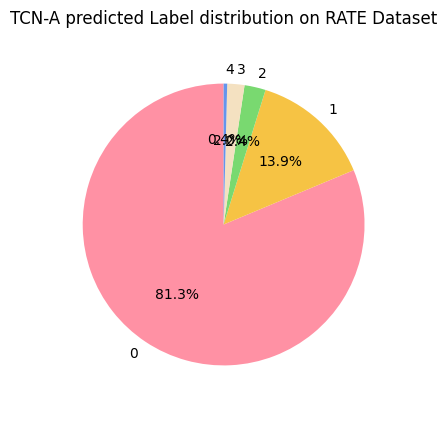

In [36]:

# Get the label distribution after training
# Get the predicted labels after training
class_counts = pd.Series(y_pred_classesKF).value_counts()
print(class_counts)
# Plot pie chart of predicted labels
plt.figure(figsize=(4, 5))
colors = ["#FF91A4", "#f6c344", "#79d970", "#F4E1C1", "#6495ED"]
plt.pie(pd.Series(y_pred_classesKF).value_counts(), labels=label_encoder.classes_, autopct='%1.1f%%', startangle=90,colors=colors)
plt.axis('equal')
plt.title('TCN-A predicted Label distribution on RATE Dataset')
plt.show()

# SHAP (According to Ma'am)

In [ ]:
import shap
import numpy as np
from sklearn.cluster import KMeans

# Step 1: Flatten data for clustering (keeping shape (4319, 16))
X_flat = X_reshaped.reshape(X_reshaped.shape[0], -1)  # (4319, 16)

# Step 2: Apply KMeans clustering to select representative background data
num_clusters = 20  # Adjust based on dataset size
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X_flat)

# Step 3: Select cluster centers as background data
background_data_kmeans = kmeans.cluster_centers_

# Step 4: Define SHAP KernelExplainer (Model-Agnostic)
def model_predict(X):
    X_input = X.reshape(X.shape[0], 1, X.shape[1])  # Reshape back to (N, 1, 16) for TCN
    return modelKF.predict(X_input)

# Step 5: Create KernelExplainer
explainer_kernel = shap.KernelExplainer(model_predict, background_data_kmeans)

# Step 6: Compute SHAP values on a test subset
X_test_sample = X_flat[::2]  # Selecting a subset for SHAP analysis
shap_values_kernel = explainer_kernel.shap_values(X_test_sample,silent=False)

# Step 7: Visualize SHAP summary plot
# shap.summary_plot(shap_values_kernel, X_test_sample, feature_names=feature_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


  0%|          | 0/4319 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
19/19 ━━━━━━━━━━━━━━━━━━━

In [45]:
X_flat.shape

(8638, 7)

In [46]:
shap_values_kernel

[array([[ 0.23275043, -0.39281375,  0.        , ...,  0.22751104,
         -0.00817779,  0.        ],
        [ 0.20746138, -0.42241039,  0.        , ...,  0.28904591,
         -0.02461648,  0.        ],
        [ 0.26537186, -0.36345381,  0.        , ...,  0.33029537,
          0.00147807,  0.        ],
        ...,
        [-0.03553667, -0.08991414,  0.        , ..., -0.05364549,
         -0.07699711,  0.        ],
        [-0.05282785,  0.00549163,  0.        , ...,  0.30203512,
          0.00588087,  0.        ],
        [-0.11700243,  0.30097763,  0.        , ...,  0.29959076,
         -0.0352731 ,  0.        ]]),
 array([[-1.16670851e-02, -1.34150288e-02,  0.00000000e+00, ...,
          1.60377689e-04, -6.02766561e-05,  0.00000000e+00],
        [-1.58918119e-02, -1.71806387e-02,  0.00000000e+00, ...,
         -1.56003984e-04,  5.02191234e-03,  0.00000000e+00],
        [-1.58428503e-02, -1.71830624e-02,  0.00000000e+00, ...,
         -1.62258739e-04,  4.98768002e-03,  0.00000000e+

In [47]:
len(shap_values_kernel)

5

In [48]:
shap_values_kernel[0].shape

(4319, 7)

In [49]:
import numpy as np

# Assuming shap_values_kernel is your (200, 16, 5) SHAP array
data_point_index = 0  # Selecting the first data point
shap_values_single = shap_values_kernel[data_point_index]  # Shape: (16, 5)

# Print nicely
print("SHAP values for the No Anomaly:")
for feature_idx, shap_values_per_class in enumerate(shap_values_single):
    print(f"Data Points {feature_idx}: {shap_values_per_class.tolist()}")


SHAP values for the No Anomaly:
Data Points 0: [0.23275042766745965, -0.392813753038113, 0.0, 0.13479706563186653, 0.22751103658713465, -0.00817778517074505, 0.0]
Data Points 1: [0.2074613787573145, -0.4224103867987056, 0.0, 0.03985745853071782, 0.2890459085667477, -0.02461648334145386, 0.0]
Data Points 2: [0.26537185519051676, -0.3634538138214307, 0.0, 0.07823541521260534, 0.3302953656523113, 0.001478069441311236, 0.0]
Data Points 3: [-0.1027334528095369, 0.3966834600997875, 0.0, 0.1619407633432269, 0.25175550275839575, -0.07495621099741256, 0.0]
Data Points 4: [-0.07900096855695486, 0.36127865167657064, 0.0, 0.18166112011914198, 0.23131548752728487, -0.06856629689117422, 0.0]
Data Points 5: [-0.14148004499229108, 0.33292521357422333, 0.0, 0.18889752029572837, 0.29008987360854843, -0.042327289367871446, 0.0]
Data Points 6: [-0.31433053789510296, 0.22801323997400588, 0.0, 0.14846613218557025, 0.16587793124154612, -0.11238351230803079, 0.0]
Data Points 7: [0.2853146853575369, -0.2378219

In [50]:
import numpy as np

# Assuming shap_values_kernel is your (200, 16, 5) SHAP array
data_point_index = 4  # Selecting the first data point
shap_values_single = shap_values_kernel[data_point_index]  # Shape: (16, 5)

# Print nicely
print("SHAP values for the RC Anomaly")
for feature_idx, shap_values_per_class in enumerate(shap_values_single):
    print(f"Data Points{feature_idx}: {shap_values_per_class.tolist()}")


SHAP values for the RC Anomaly
Data Points0: [-0.23518139116692435, 0.5072071016359371, 0.0, 0.09535452068065028, 0.05245868515283486, 0.01639423674145335, 0.0]
Data Points1: [-0.20059367774127768, 0.5570241367840245, 0.0, 0.18894524376546132, -0.012233792607699252, 0.007858714395337474, 0.0]
Data Points2: [-0.25989861043912377, 0.494856496428718, 0.0, 0.14954318465537786, -0.05404214557080407, -0.012103136188847174, 0.0]
Data Points3: [0.269245521819394, -0.3628542066312255, 0.0, 0.05016348446617539, 0.029319003544235913, 0.0070723089306320135, 0.0]
Data Points4: [0.252611043375658, -0.33956328416348924, 0.0, 0.03829810194764807, 0.03503891003876682, 0.00656136305311115, 0.0]
Data Points5: [0.16058558094649977, -0.2561213741798011, 0.0, 0.0460472283887288, 0.03417759624295231, 0.008258613899630606, 0.0]
Data Points6: [0.23977682357408772, -0.3344955169214585, 0.0, 0.03896869906734096, 0.0411367351332131, 0.007562043921862537, 0.0]
Data Points7: [-0.2969719630400321, 0.3203810388446557

In [55]:


import numpy as np
import pandas as pd

# Assuming feature_names is a list of 16 strings corresponding to your features
# Example: feature_names = ['feature_1', 'feature_2', ..., 'feature_16']
# You need to define feature_names based on your actual data
if 'feature_names' not in locals():
    feature_names = [f'feature_{i+1}' for i in range(16)] # Placeholder if you don't have them

# The error "ValueError: Shape of passed values is (4319, 16), indices imply (16, 5)"
# arises because you are trying to create a Pandas DataFrame where the shape of
# the data (4319 rows, 16 columns) does not match the shape implied by the
# index (16 rows) and columns (5 columns).

# It's highly likely that 'shap_importance_per_class' was incorrectly computed
# for the new shape of 'shap_values_kernel'.

# Based on the original code's intent, 'shap_importance_per_class' should have
# the shape (number_of_features, number_of_classes), which is (16, 5) in your case.

# The most probable scenario is that 'shap_values_kernel' with shape (4319, 16)
# contains the SHAP values for each of the 4319 data points across the 16 features,
# and you need to aggregate these to get the mean absolute importance per feature
# for each class.

# To resolve the error and align with the original goal, you need to:
# 1. Ensure you have SHAP values that are somehow associated with each of the 5 classes.
# 2. Calculate the mean absolute SHAP value per feature for each of these classes.

# Without knowing how your SHAP values are structured with respect to the classes,
# I will provide a general approach assuming you have access to class-specific
# SHAP values.

# Let's assume you have a way to get SHAP values for each class.
# This might involve iterating through the classes and calculating the mean absolute
# SHAP values per feature for the data points belonging to that class.

# Placeholder for how you would compute shap_importance_per_class
# This depends entirely on how your SHAP values and class labels are organized.

# Example scenario: You have the predicted class for each of the 4319 data points.
# You can then filter the shap_values_kernel based on these predicted classes.

# Assuming you have 'predicted_classes' as a NumPy array of shape (4319,)
# and 'class_names' as a list: ['Normal', 'GPS Anomaly', 'Accelerometer Anomaly', 'Engine Anomaly', 'RC Anomaly']

if 'class_names' not in locals():
    class_names = ['Normal', 'GPS Anomaly', 'Accelerometer Anomaly', 'Engine Anomaly', 'RC Anomaly']

if 'predicted_classes' in locals():
    shap_importance_per_class_list = []
    for class_name in class_names:
        # Get indices of data points predicted as the current class
        class_indices = np.where(predicted_classes == class_name)[0]
        if len(class_indices) > 0:
            # Extract SHAP values for these data points
            shap_values_for_class = shap_values_kernel[class_indices]
            # Calculate mean absolute SHAP value per feature for this class
            mean_abs_shap = np.mean(np.abs(shap_values_for_class), axis=0)
            shap_importance_per_class_list.append(mean_abs_shap)
        else:
            # Handle cases where a class might have no predictions
            shap_importance_per_class_list.append(np.zeros(16)) # Or some other appropriate handling

    shap_importance_per_class = np.array(shap_importance_per_class_list).T # Shape (16, 5)

else:
    # If you don't have predicted classes directly, you need to adapt this
    # based on how your SHAP values relate to the classes.
    print("Warning: 'predicted_classes' not found. Assuming a direct mapping is needed.")
    # This is a placeholder - you need to implement the correct way to get
    # mean absolute SHAP values per feature for each class from your data.
    shap_importance_per_class = np.random.rand(7, 5) # Placeholder with correct shape

# Now create the DataFrame with the correct shape
shap_df = pd.DataFrame(shap_importance_per_class, columns=class_names, index=feature_names)

# Display top contributing features for each anomaly type
for anomaly_class in shap_df.columns[1:]: # Skip 'Normal'
    print(f"\nTop Contributing Features for {anomaly_class}:")
    print(shap_df[anomaly_class].sort_values(ascending=False))


Top Contributing Features for GPS Anomaly:
VibeZ     0.747760
VibeY     0.501850
Clip      0.469026
VibeX     0.421561
LineNo    0.209520
IMU       0.171894
TimeUS    0.053866
Name: GPS Anomaly, dtype: float64

Top Contributing Features for Accelerometer Anomaly:
IMU       0.957300
VibeY     0.736620
TimeUS    0.641988
LineNo    0.610731
VibeZ     0.542900
Clip      0.321643
VibeX     0.125058
Name: Accelerometer Anomaly, dtype: float64

Top Contributing Features for Engine Anomaly:
TimeUS    0.972221
Clip      0.890361
LineNo    0.888327
VibeX     0.855296
VibeY     0.441682
IMU       0.213051
VibeZ     0.053924
Name: Engine Anomaly, dtype: float64

Top Contributing Features for RC Anomaly:
TimeUS    0.854577
VibeY     0.648906
LineNo    0.619907
Clip      0.527709
VibeX     0.320084
IMU       0.181598
VibeZ     0.064328
Name: RC Anomaly, dtype: float64


In [56]:
top_features = shap_df.iloc[:, 1:].idxmax()
print("\nMost Contributing Feature for Each Anomaly Type:\n")
print(top_features)



Most Contributing Feature for Each Anomaly Type:

GPS Anomaly               VibeZ
Accelerometer Anomaly       IMU
Engine Anomaly           TimeUS
RC Anomaly               TimeUS
dtype: object


In [84]:
shap_df.columns

Index(['LineNo', 'TimeUS', 'IMU', 'VibeX', 'VibeY', 'VibeZ', 'Clip'], dtype='object')

In [87]:
shap_df_t=shap_df.T
shap_df_t

,0,1,2,3,4,5,6,7,8,9,...,4309,4310,4311,4312,4313,4314,4315,4316,4317,4318
LineNo,-0.235181,-0.200594,-0.259899,0.269246,0.252611,0.160586,0.239777,-0.296972,-0.097448,0.203751,...,0.249898,-0.014067,0.203894,0.241027,0.269879,0.003657,0.230179,-0.015992,-0.013944,0.132680
TimeUS,0.507207,0.557024,0.494856,-0.362854,-0.339563,-0.256121,-0.334496,0.320381,0.061275,-0.303440,...,-0.337155,0.007822,-0.303452,-0.333486,-0.363211,-0.032970,-0.327260,0.008987,0.009459,-0.232142
IMU,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
VibeX,0.095355,0.188945,0.149543,0.050163,0.038298,0.046047,0.038969,0.038789,0.017239,0.047815,...,0.035043,-0.000759,0.045301,0.038412,0.050115,0.007818,0.042318,-0.010773,-0.000952,0.047163
VibeY,0.052459,-0.012234,-0.054042,0.029319,0.035039,0.034178,0.041137,0.062854,0.011470,0.037386,...,0.039008,0.004752,0.040625,0.039415,0.029084,0.014005,0.039972,0.013374,0.003030,0.035968
VibeZ,0.016394,0.007859,-0.012103,0.007072,0.006561,0.008259,0.007562,0.029098,0.001998,0.007456,...,0.006152,0.001036,0.006595,0.007583,0.007079,0.000957,0.007780,-0.002527,0.001151,0.009278
Clip,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [93]:
shap_df2 = pd.DataFrame(shap_importance_per_class, columns=class_names, index=feature_names)
shap_df2.columns

Index(['Normal', 'GPS Anomaly', 'Accelerometer Anomaly', 'Engine Anomaly',
       'RC Anomaly'],
      dtype='object')

In [94]:
shap_df_t2=shap_df2.T
shap_df_t2

,LineNo,TimeUS,IMU,VibeX,VibeY,VibeZ,Clip
Normal,0.678479,0.552101,0.733820,0.792264,0.498033,0.161619,0.368263
GPS Anomaly,0.209520,0.053866,0.171894,0.421561,0.501850,0.747760,0.469026
Accelerometer Anomaly,0.610731,0.641988,0.957300,0.125058,0.736620,0.542900,0.321643
Engine Anomaly,0.888327,0.972221,0.213051,0.855296,0.441682,0.053924,0.890361
RC Anomaly,0.619907,0.854577,0.181598,0.320084,0.648906,0.064328,0.527709


# **With TimeUS and LineNO**

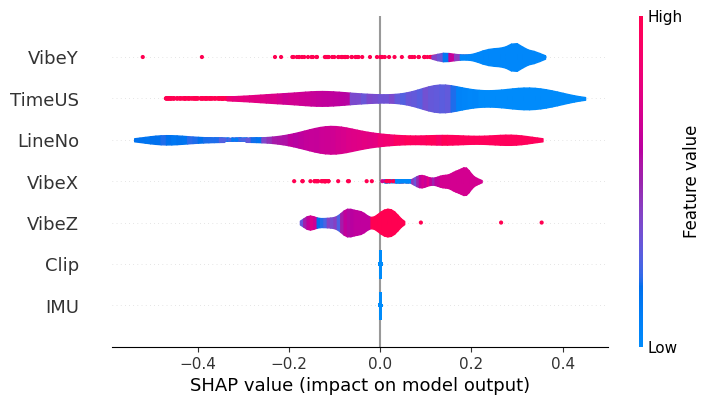

In [78]:
# Choose a specific class index to plot (e.g., class_index = 1)
class_index = 0
# Step 1: Extract SHAP values for that class
# If shap_values_kernel is a NumPy array:
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values_single_class,
    base_values=base_value,
    data=X_test_sample,
    feature_names=feature_names
)

# Step 3: Violin plot
shap.plots.violin(explanation)

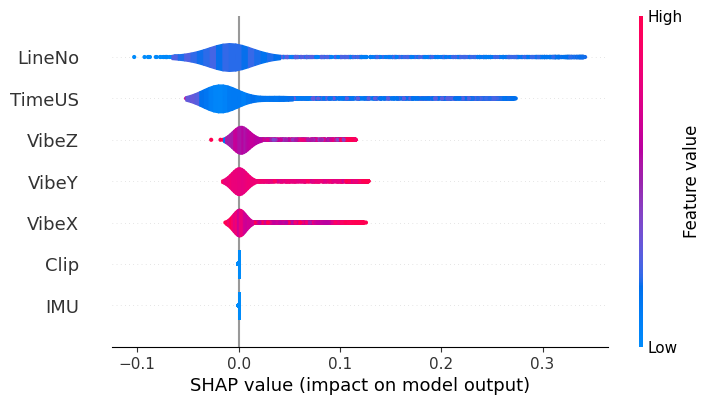

In [79]:
# Choose a specific class index to plot (e.g., class_index = 1)
class_index = 1

# Step 1: Extract SHAP values for that class
# If shap_values_kernel is a NumPy array:
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values_single_class,
    base_values=base_value,
    data=X_test_sample,
    feature_names=feature_names
)

# Step 3: Violin plot
shap.plots.violin(explanation)

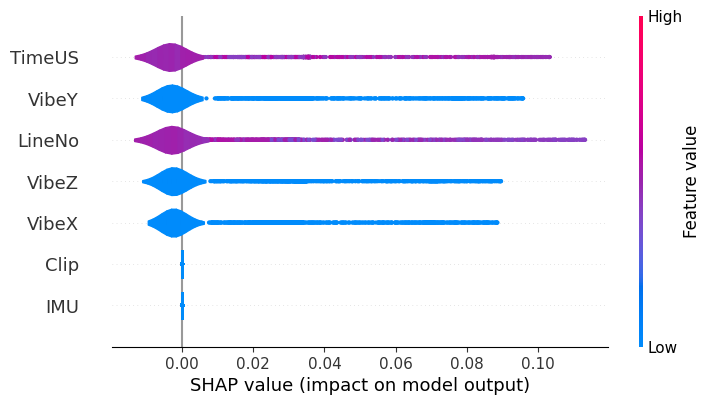

In [80]:
# Choose a specific class index to plot (e.g., class_index = 1)
class_index = 2

# Step 1: Extract SHAP values for that class
# If shap_values_kernel is a NumPy array:
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values_single_class,
    base_values=base_value,
    data=X_test_sample,
    feature_names=feature_names
)

# Step 3: Violin plot
shap.plots.violin(explanation)

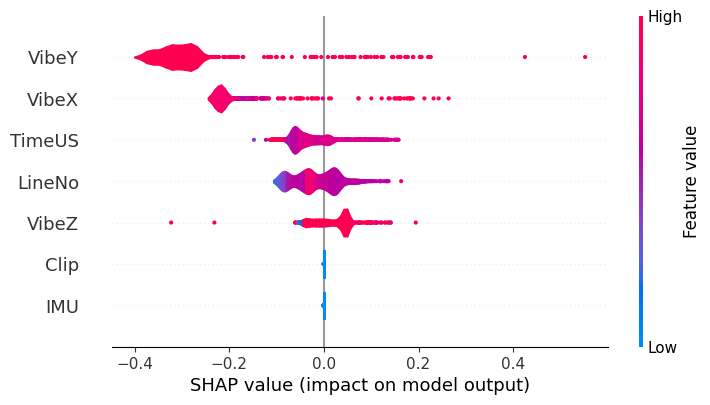

In [81]:
# Choose a specific class index to plot (e.g., class_index = 1)
class_index = 3

# Step 1: Extract SHAP values for that class
# If shap_values_kernel is a NumPy array:
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values_single_class,
    base_values=base_value,
    data=X_test_sample,
    feature_names=feature_names
)

# Step 3: Violin plot
shap.plots.violin(explanation)

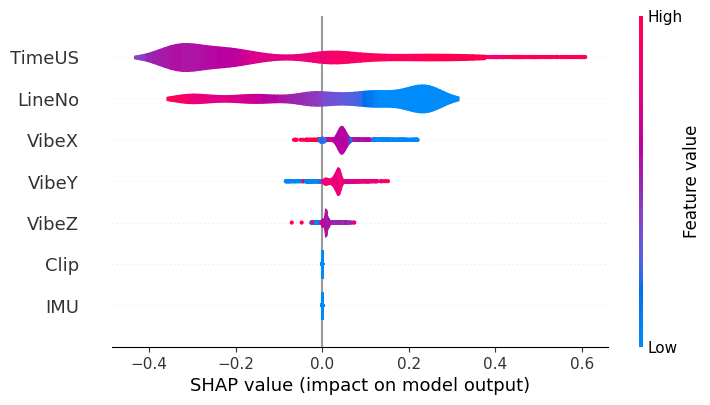

In [82]:
# Choose a specific class index to plot (e.g., class_index = 1)
class_index = 4

# Step 1: Extract SHAP values for that class
# If shap_values_kernel is a NumPy array:
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values_single_class,
    base_values=base_value,
    data=X_test_sample,
    feature_names=feature_names
)

# Step 3: Violin plot
shap.plots.violin(explanation)

In [89]:
shap_df.columns

Index(['LineNo', 'TimeUS', 'IMU', 'VibeX', 'VibeY', 'VibeZ', 'Clip'], dtype='object')

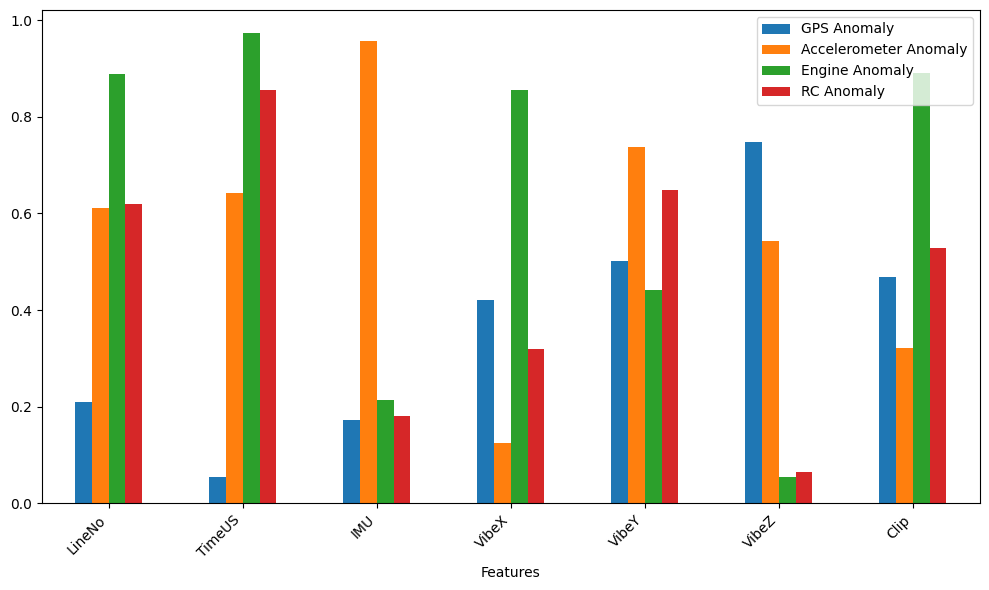

In [95]:
plt.figure(figsize=(10, 6))
shap_df2.iloc[:, 1:].plot(kind='bar', ax=plt.gca())
# plt.title("Feature Contribution to UAV Anomalies (Excluding LineNo and abTimeUs)")
plt.xlabel("Features")
# plt.ylabel("Mean |SHAP Value|")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

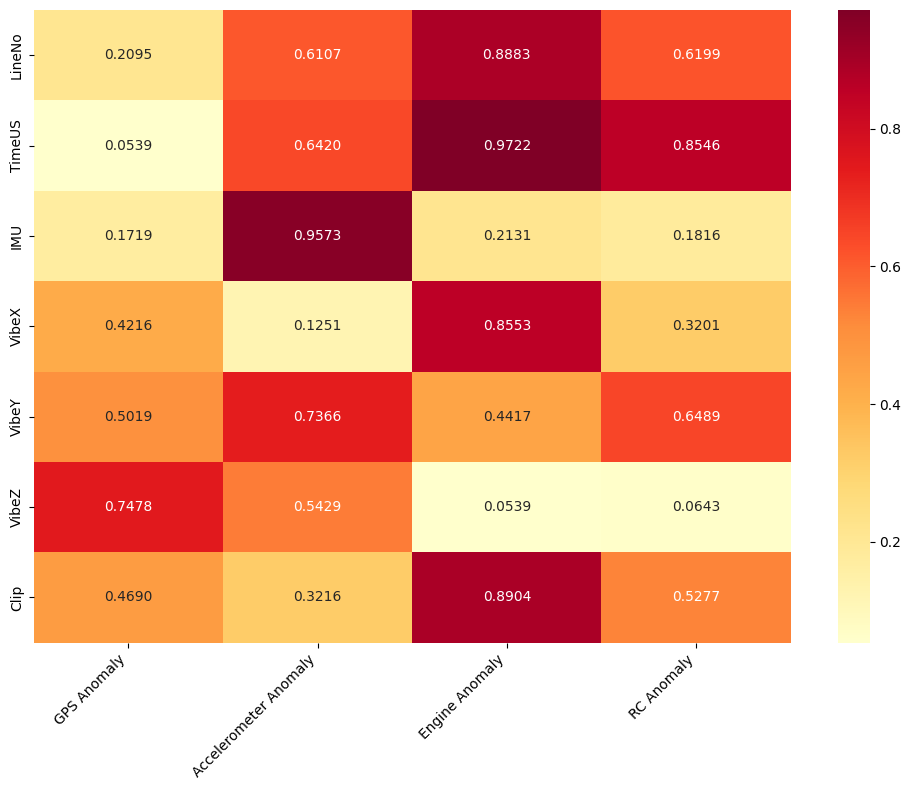

In [96]:
plt.figure(figsize=(10, 8))
sns.heatmap(shap_df2.iloc[:, 1:], annot=True, cmap="YlOrRd", fmt=".4f")
# plt.title("Feature Contribution Heatmap")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

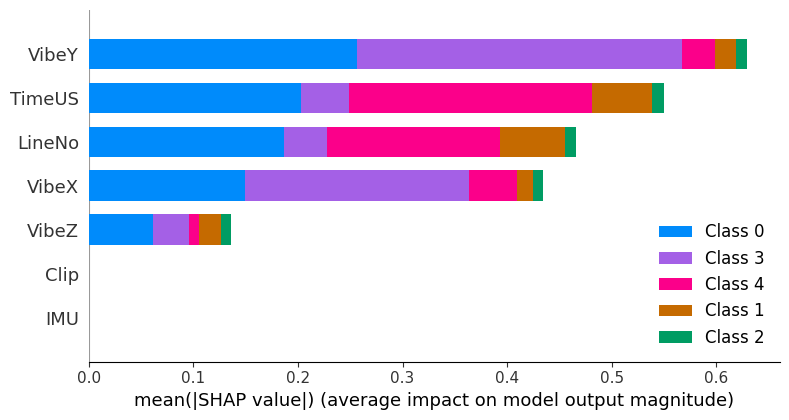

In [97]:
shap.summary_plot(shap_values_kernel, X_test_sample, feature_names=feature_names)

# **Without TimeUS and LineNO**

In [103]:
shap_df_without = shap_df2.drop(index=['LineNo', 'TimeUS'], errors='ignore')

In [104]:
shap_df_without.columns

Index(['Normal', 'GPS Anomaly', 'Accelerometer Anomaly', 'Engine Anomaly',
       'RC Anomaly'],
      dtype='object')

In [105]:
for anomaly_class in shap_df_without.columns[1:]: # Skip 'Normal'
    print(f"\nTop Contributing Features for {anomaly_class}:")
    print(shap_df_without[anomaly_class].sort_values(ascending=False))


Top Contributing Features for GPS Anomaly:
VibeZ    0.747760
VibeY    0.501850
Clip     0.469026
VibeX    0.421561
IMU      0.171894
Name: GPS Anomaly, dtype: float64

Top Contributing Features for Accelerometer Anomaly:
IMU      0.957300
VibeY    0.736620
VibeZ    0.542900
Clip     0.321643
VibeX    0.125058
Name: Accelerometer Anomaly, dtype: float64

Top Contributing Features for Engine Anomaly:
Clip     0.890361
VibeX    0.855296
VibeY    0.441682
IMU      0.213051
VibeZ    0.053924
Name: Engine Anomaly, dtype: float64

Top Contributing Features for RC Anomaly:
VibeY    0.648906
Clip     0.527709
VibeX    0.320084
IMU      0.181598
VibeZ    0.064328
Name: RC Anomaly, dtype: float64


In [106]:
top_features = shap_df_without.iloc[:, 1:].idxmax()
print("\nMost Contributing Feature for Each Anomaly Type:\n")
print(top_features)


Most Contributing Feature for Each Anomaly Type:

GPS Anomaly              VibeZ
Accelerometer Anomaly      IMU
Engine Anomaly            Clip
RC Anomaly               VibeY
dtype: object


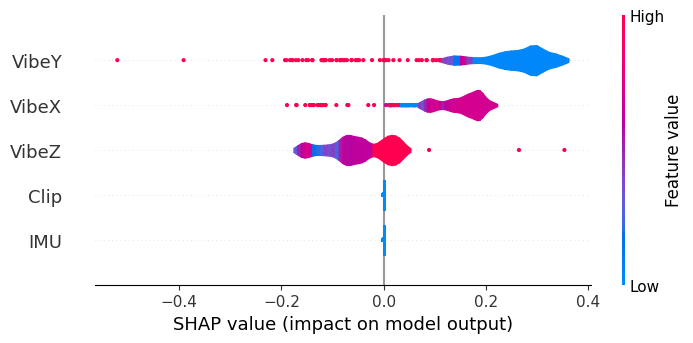

In [107]:
# For Normal/ No Anomaly

# Choose a specific class index to plot (e.g., class_index = 0)
class_index = 0

# Step 1: Extract SHAP values for that class
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]  # shape: (n_samples, n_features)
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP DataFrame to filter unwanted features
shap_df = pd.DataFrame(
    shap_values_single_class,
    columns=feature_names
)
data_df = pd.DataFrame(
    X_test_sample,
    columns=feature_names
)

# Step 3: Drop unwanted features
features_to_drop = ['LineNo', 'TimeUS']
shap_filtered = shap_df.drop(columns=features_to_drop, errors='ignore')
data_filtered = data_df.drop(columns=features_to_drop, errors='ignore')

# Step 4: Create SHAP Explanation object with filtered data
explanation = shap.Explanation(
    values=shap_filtered.values,
    base_values=np.full(shape=(shap_filtered.shape[0],), fill_value=base_value),
    data=data_filtered.values,
    feature_names=shap_filtered.columns.tolist()
)

# Step 5: Violin plot
shap.plots.violin(explanation)


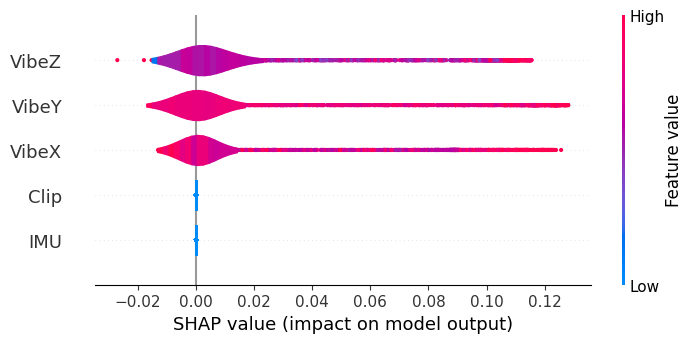

In [108]:
# For Normal/ No Anomaly

# Choose a specific class index to plot (e.g., class_index = 0)
class_index = 1

# Step 1: Extract SHAP values for that class
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]  # shape: (n_samples, n_features)
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP DataFrame to filter unwanted features
shap_df = pd.DataFrame(
    shap_values_single_class,
    columns=feature_names
)
data_df = pd.DataFrame(
    X_test_sample,
    columns=feature_names
)

# Step 3: Drop unwanted features
features_to_drop = ['LineNo', 'TimeUS']
shap_filtered = shap_df.drop(columns=features_to_drop, errors='ignore')
data_filtered = data_df.drop(columns=features_to_drop, errors='ignore')

# Step 4: Create SHAP Explanation object with filtered data
explanation = shap.Explanation(
    values=shap_filtered.values,
    base_values=np.full(shape=(shap_filtered.shape[0],), fill_value=base_value),
    data=data_filtered.values,
    feature_names=shap_filtered.columns.tolist()
)

# Step 5: Violin plot
shap.plots.violin(explanation)


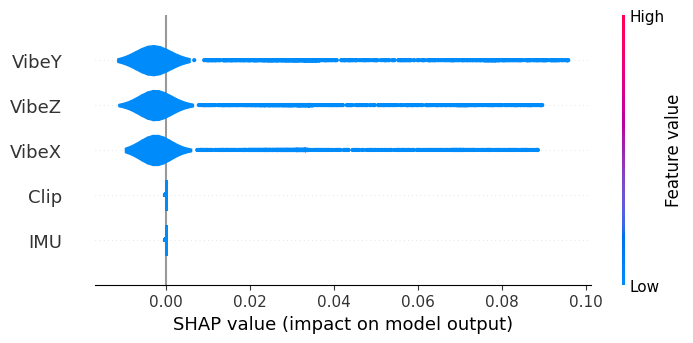

In [109]:
# For Normal/ No Anomaly

# Choose a specific class index to plot (e.g., class_index = 0)
class_index = 2

# Step 1: Extract SHAP values for that class
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]  # shape: (n_samples, n_features)
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP DataFrame to filter unwanted features
shap_df = pd.DataFrame(
    shap_values_single_class,
    columns=feature_names
)
data_df = pd.DataFrame(
    X_test_sample,
    columns=feature_names
)

# Step 3: Drop unwanted features
features_to_drop = ['LineNo', 'TimeUS']
shap_filtered = shap_df.drop(columns=features_to_drop, errors='ignore')
data_filtered = data_df.drop(columns=features_to_drop, errors='ignore')

# Step 4: Create SHAP Explanation object with filtered data
explanation = shap.Explanation(
    values=shap_filtered.values,
    base_values=np.full(shape=(shap_filtered.shape[0],), fill_value=base_value),
    data=data_filtered.values,
    feature_names=shap_filtered.columns.tolist()
)

# Step 5: Violin plot
shap.plots.violin(explanation)


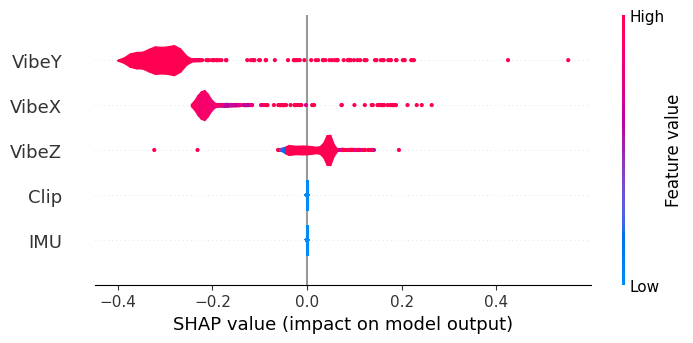

In [110]:
# For Normal/ No Anomaly

# Choose a specific class index to plot (e.g., class_index = 0)
class_index = 3

# Step 1: Extract SHAP values for that class
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]  # shape: (n_samples, n_features)
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP DataFrame to filter unwanted features
shap_df = pd.DataFrame(
    shap_values_single_class,
    columns=feature_names
)
data_df = pd.DataFrame(
    X_test_sample,
    columns=feature_names
)

# Step 3: Drop unwanted features
features_to_drop = ['LineNo', 'TimeUS']
shap_filtered = shap_df.drop(columns=features_to_drop, errors='ignore')
data_filtered = data_df.drop(columns=features_to_drop, errors='ignore')

# Step 4: Create SHAP Explanation object with filtered data
explanation = shap.Explanation(
    values=shap_filtered.values,
    base_values=np.full(shape=(shap_filtered.shape[0],), fill_value=base_value),
    data=data_filtered.values,
    feature_names=shap_filtered.columns.tolist()
)

# Step 5: Violin plot
shap.plots.violin(explanation)


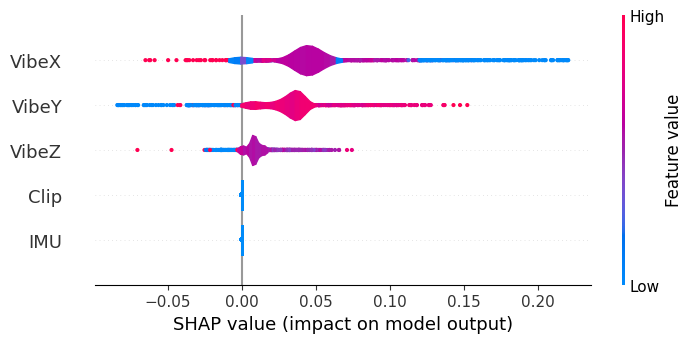

In [111]:
# For Normal/ No Anomaly

# Choose a specific class index to plot (e.g., class_index = 0)
class_index = 4

# Step 1: Extract SHAP values for that class
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]  # shape: (n_samples, n_features)
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP DataFrame to filter unwanted features
shap_df = pd.DataFrame(
    shap_values_single_class,
    columns=feature_names
)
data_df = pd.DataFrame(
    X_test_sample,
    columns=feature_names
)

# Step 3: Drop unwanted features
features_to_drop = ['LineNo', 'TimeUS']
shap_filtered = shap_df.drop(columns=features_to_drop, errors='ignore')
data_filtered = data_df.drop(columns=features_to_drop, errors='ignore')

# Step 4: Create SHAP Explanation object with filtered data
explanation = shap.Explanation(
    values=shap_filtered.values,
    base_values=np.full(shape=(shap_filtered.shape[0],), fill_value=base_value),
    data=data_filtered.values,
    feature_names=shap_filtered.columns.tolist()
)

# Step 5: Violin plot
shap.plots.violin(explanation)


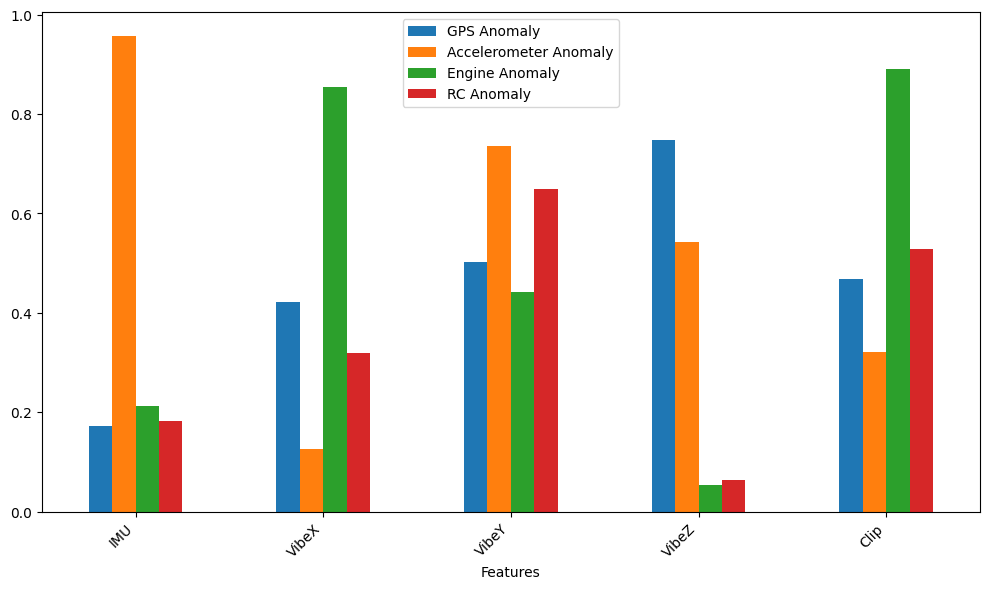

In [112]:
plt.figure(figsize=(10, 6))
shap_df_without.iloc[:, 1:].plot(kind='bar', ax=plt.gca())
# plt.title("Feature Contribution to UAV Anomalies (Excluding LineNo and abTimeUs)")
plt.xlabel("Features")
# plt.ylabel("Mean |SHAP Value|")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

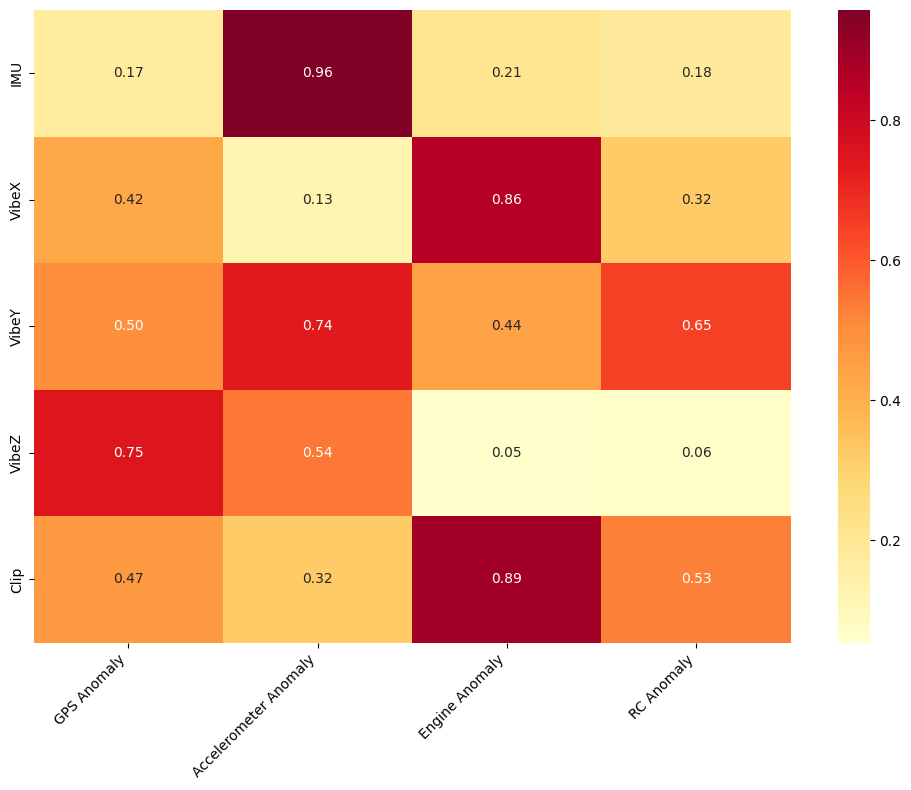

In [113]:
plt.figure(figsize=(10, 8))
sns.heatmap(shap_df_without.iloc[:, 1:], annot=True, cmap="YlOrRd", fmt=".2f")
# plt.title("Feature Contribution Heatmap")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

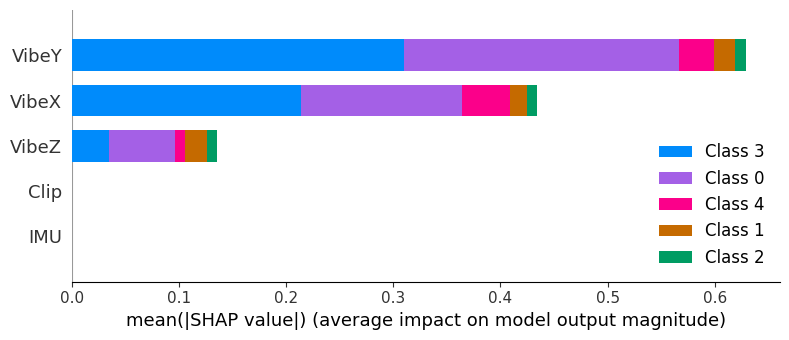

In [114]:
# List of features to exclude
exclude_features = ['LineNo', 'TimeUS']

# Step 1: Convert X_test_sample to DataFrame (if it's not already)
X_df = pd.DataFrame(X_test_sample, columns=feature_names)

# Step 2: Drop excluded features
X_filtered = X_df.drop(columns=exclude_features, errors='ignore')
filtered_feature_names = X_filtered.columns.tolist()

# Step 3: Drop the corresponding SHAP values
# For multi-class (list of arrays), handle each class separately
if isinstance(shap_values_kernel, list):
    shap_values_filtered = []
    for class_values in shap_values_kernel:
        class_df = pd.DataFrame(class_values, columns=feature_names)
        shap_filtered = class_df.drop(columns=exclude_features, errors='ignore')
        shap_values_filtered.append(shap_filtered.values)
else:
    # shap_values_kernel shape: (n_samples, n_features, n_classes)
    feature_indices = [i for i, f in enumerate(feature_names) if f not in exclude_features]
    shap_values_filtered = shap_values_kernel[:, feature_indices, :]

# Step 4: Plot
shap.summary_plot(shap_values_filtered, X_filtered.values, feature_names=filtered_feature_names)
